# Performing Optimal Transport on blades

This notebook is in addition of the Experiment_On_Real_Dataset notebook. Its aim is to understand and visualize the optimal transport problem from a refrence measure to a blade and from a blade to another one.

<br>

Authors of this notebook:
* Louis Allain
* Léonard Gousset
* Julien Heurtin

## Regularized Optimal Transport between two blades

This section is dedicated to perform ROT between two cloud points. It is mainly here to help us understand every steps needed to perform ROT using ```jax``` and ```ott``` packages. From here we will determine the best way to carry the ROT problem between two large samples, trading off between memory and time.

In [1]:
from packages import *
import importing

# Jax package allows to speed up computation
import jax.numpy as jnp

# Packages that actually performs Sinkhorn algorithm
from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn
import ott
distributions = importing.blades2(ids = [0, 1, 2])


In [2]:
# Start a timer
import time
start_time = time.time()


## First les take two first blade
blade_one = distributions[0]
blade_two = distributions[1]

## How many points per blade ?
size_cloud_points = len(blade_one)

## We need to define the clouds as jax.numpy arrays
cloud_one = jnp.array(blade_one)
cloud_two = jnp.array(blade_two)

## Define the epsilon for Regularized OT - small epsilon = great accuracy = longer time
epsilon = 1e-03

## Create PointCloud object to accomodate OTT package
my_geom = PointCloud(x = cloud_one, # training cloud or first blade cloud
                  y = cloud_two, # reference cloud or second blade cloud
                  epsilon = epsilon # epsilon of ROT
                  )

## Formalises the Regularized Optimal Transport problem
ot_problem = LinearProblem(geom = my_geom) # The geometry of the problem between the two blades

## Instanciate the solver of the ROT problem
sinkhorn_solver =  Sinkhorn()

## Actually computing the Sinkhorn algortihm
rot_result = sinkhorn_solver(ot_problem)

# Stops the timer
end_time = time.time()
time_spent = end_time - start_time
print("Regularized Optimal Transport computation took:", time_spent, "seconds, using epsilon =", epsilon)


## Retrieve left and right potentials
left_potentials = rot_result.f
right_potentials = rot_result.g

## Retrieve the duals potentials
dual_potentials = rot_result.to_dual_potentials()

## Compute the transport plan matrix
transport_plan_matrix = rot_result.matrix

Regularized Optimal Transport computation took: 61.65154004096985 seconds, using epsilon = 0.001


In [3]:
rot_result.ent_reg_cost

Array(-0.01935494, dtype=float32)

### Plotting the Transport Plan Matrix

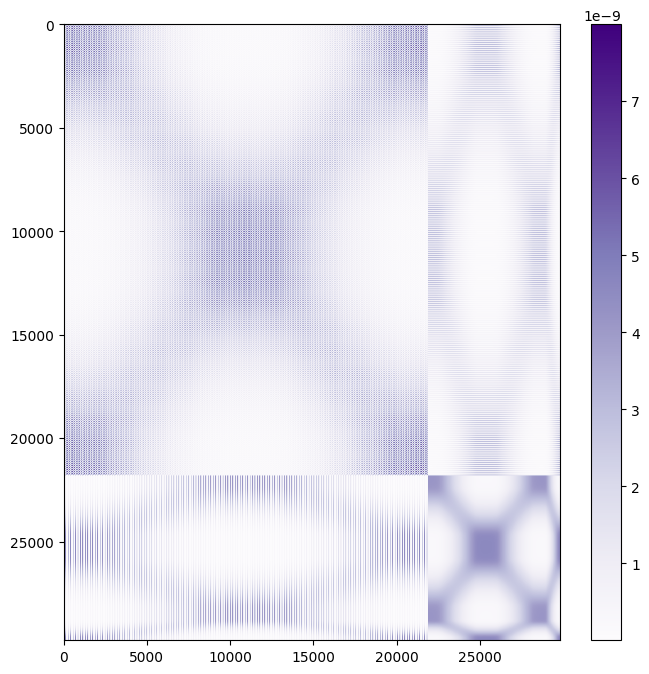

In [4]:
plt.figure(figsize=(8, 8))

# Heatmap visualization of transport plan matrix
plt.imshow(transport_plan_matrix, cmap = "Purples", aspect='auto')
#plt.title('Transport Plan Heatmap\nAgainst another blade')
plt.colorbar()

# Save the figure
plt.savefig("Images/transport_plan_matrix_blade.png", dpi=1000, bbox_inches='tight', format="png")
# Show the figure
plt.show()

### Plotting the Sinkhorn potentials

In [ ]:
# Define colors for left and right potentials
left_color = 'blue'
right_color = 'orange'

# Calculate the difference between left and right potentials
potential_difference = [left - right for left, right in zip(left_potentials, right_potentials)]

# Plotting the results
plt.figure(figsize=(18, 4))  # Adjust figsize as needed

# Left potentials plot
plt.subplot(1, 4, 1)
plt.plot(left_potentials, label='Left Potentials', color=left_color)
plt.legend()
plt.title('Left Potentials')

# Dual potentials plot
plt.subplot(1, 4, 2)
plt.plot(left_potentials, label='Left Potentials', color=left_color)
plt.plot(right_potentials, label='Right Potentials', color=right_color)
plt.legend()
plt.title('Dual Potentials')

# Right potentials plot
plt.subplot(1, 4, 3)
plt.plot(right_potentials, label='Right Potentials', color=right_color)
plt.legend()
plt.title('Right Potentials')

# Potential difference plot
plt.subplot(1, 4, 4)
plt.plot(potential_difference, label='Potential Difference', color='green')
plt.legend()
plt.title('Potential Difference')

plt.tight_layout()

#plt.savefig("Images/transport_plan_matrix_2_blades.png", dpi=300, bbox_inches='tight', format="png")

plt.show()


In [ ]:
# Define colors for left and right potentials
left_color = 'blue'
right_color = 'orange'

# Calculate the difference between left and right potentials
potential_difference = [left - right for left, right in zip(left_potentials, right_potentials)]

# Plotting the results
plt.figure(figsize=(18, 4))  # Adjust figsize as needed

# Left potentials plot
plt.plot(left_potentials, label='Left Potentials', color=left_color)

# Dual potentials plot
plt.plot(left_potentials, label='Left Potentials', color=left_color)
plt.plot(right_potentials, label='Right Potentials', color=right_color)

# Right potentials plot
plt.plot(right_potentials, label='Right Potentials', color=right_color)

# Potential difference plot
plt.plot(potential_difference, label='Potential Difference', color='green')

# Add legend outside the subplots
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Set common title for all subplots
plt.suptitle('Optimal Transport Results')

plt.tight_layout()

#plt.savefig("Images/transport_plan_matrix_2_blades.png", dpi=300, bbox_inches='tight', format="png")

plt.show()


### Plotting the transport map

Using the tutorial [here](https://ott-jax.readthedocs.io/en/latest/tutorials/point_clouds.html).

In [ ]:
## This does not work, but I cannot figure out why.

# Plotting utility
def plot_map(x, y, z, forward: bool = True):
    plt.figure(figsize=(10, 8))
    marker_t = "o" if forward else "X"
    label = (
        r"$T_{x\rightarrow y}(x)$" if forward else r"$T_{y\rightarrow x}(y)$"
    )
    w = x if forward else y
    plt.quiver(
        *w.T,
        *(z - w).T,
        color="k",
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.007,
    )
    plt.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    plt.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    plt.scatter(*z.T, s=150, edgecolors="k", marker=marker_t, label=label)
    plt.legend(fontsize=22)

# Computing the transport
transport = dual_potentials.transport(cloud_one)

# Actually plotting the transpot map
plot_map(cloud_one, cloud_two, transport)

In [ ]:
## Some other way, that seems to work but the plot is not usable/readable...

plott = ott.tools.plot.Plot()
_ = plott(rot_result)

## Regularized Optimal Transport between a reference measure and a blade

The reference measure considered here is a sphere of center the barycenter of the blade and of small radius (0.04). This refrence measure is only considered to perform Regularized Optimal Transport and to analyse its behaviour.

### Defining a few utilities functions

In [ ]:
def calculate_barycenter(points):
    num_points = len(points)
    if num_points == 0:
        raise ValueError("Cannot calculate the barycenter of an empty set of points.")
    
    # Sum the coordinates along each axis
    sum_x = np.sum(points[:, 0])
    sum_y = np.sum(points[:, 1])
    sum_z = np.sum(points[:, 2])
    
    # Calculate the barycenter coordinates
    barycenter_x = sum_x / num_points
    barycenter_y = sum_y / num_points
    barycenter_z = sum_z / num_points
    
    return barycenter_x, barycenter_y, barycenter_z

def sample_points_on_sphere(num_points, radius = 1, center = (0, 0, 0)):
    # Generate random values for θ and φ
    theta = np.random.uniform(0, np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)
    
    # Calculate Cartesian coordinates
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)
    
    return x, y, z

### Choosing the blade and sampling the reference measure

In [ ]:
## Choosing the blade
blade_one = distributions[1]
x, y, z = blade_one[:, 0], blade_one[:, 1], blade_one[:, 2]
# Calculate the barycenter of the blade
barycenter_x, barycenter_y, barycenter_z = calculate_barycenter(blade_one)

## Sampling the sphere of a given radius and of center the barycenter of the blade
num_points = 1000
radius = 0.04
ref_x, ref_y, ref_z = sample_points_on_sphere(num_points, radius = radius, center = (barycenter_x, barycenter_y, barycenter_z))
reference_measure_sample = np.column_stack((ref_x, ref_y, ref_z))


### Plotting the blade and the reference measure sample

In [ ]:
## Plotting plotly figure

# Create traces for each set of coordinates
trace1 = go.Scatter3d(x=reference_measure_sample[:, 0], y=reference_measure_sample[:, 1], z=reference_measure_sample[:, 2], mode='markers', marker=dict(size=8, color='blue'), name='Reference Measure')
trace2 = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=8, color='red'), name='Blade')

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2])

# Update layout for better visualization
fig.update_layout(scene=dict(aspectmode='data'))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis'))

# Show the plot
fig.show()

### Performing Regularized Optimal Transport between the blade and the reference measure sample

The functions from the paper normalized the reference measure. Is it necessary here ?

In [ ]:
# Jax package allows to speed up computation
import jax.numpy as jnp

# Packages that actually performs Sinkhorn algorithm
from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn
import ott

## We sample from our reference measure.

# Start a timer
import time
start_time = time.time()

## Our cloud points are in the variables blade_one and reference_measure_sample

## How many points per blade ?
size_cloud_points = len(blade_one)

## We need to define the clouds as jax.numpy arrays
cloud_one = jnp.array(blade_one)
cloud_ref = jnp.array(reference_measure_sample)

## The functions from the paper normalized the reference measure. Is it necessary here ?

## Define the epsilon for Regularized OT - small epsilon = great accuracy = longer time
epsilon = 1e-03

## Create PointCloud object to accomodate OTT package
my_geom = PointCloud(x = cloud_one, # training cloud or first blade cloud
                  y = cloud_ref, # reference cloud or second blade cloud
                  epsilon = epsilon # epsilon of ROT
                  )

## Formalises the Regularized Optimal Transport problem
ot_problem = LinearProblem(geom = my_geom) # The geometry of the problem between the two blades

## Instanciate the solver of the ROT problem
sinkhorn_solver =  Sinkhorn()

## Actually computing the Sinkhorn algortihm
rot_result = sinkhorn_solver(ot_problem)

# Stops the timer
end_time = time.time()
time_spent = end_time - start_time
print("Regularized Optimal Transport computation took:", time_spent, "seconds, using epsilon =", epsilon)

## Retrieve left and right potentials
left_potentials = rot_result.f
right_potentials = rot_result.g

## Retrieve the duals potentials
dual_potentials = rot_result.to_dual_potentials()

## Compute the transport plan matrix
transport_plan_matrix = rot_result.matrix

In [ ]:
rot_result.ent_reg_cost